In [10]:
import pandas as pd
file = "length_norm_entropy_9.short.csv"
original_df = pd.read_csv(file)
step_size = original_df['n_attempts'].max()
# original_df.drop(['Unnamed: 0'], inplace=True)
original_df['is_correct'] = (original_df['acronym'] == original_df['ground_truth'])
original_df['before_feedback_entropy'] = -original_df['before_feedback_entropy']
original_df['after_feedback_entropy'] = -original_df['after_feedback_entropy']



In [81]:
already_correct = set()
cumulative_correct = 0
N = original_df['ground_truth'].nunique()
for iter in range(step_size):
    initial_df = original_df[original_df['n_attempts'] == iter]
    a = (initial_df['acronym'] == initial_df['ground_truth'])
    a = a & ~initial_df['ground_truth'].isin(already_correct)
    b = a.sum()
    c = len(a)
    already_correct.update(initial_df[a]['ground_truth'])
    cumulative_correct += b
    print(iter, b / c, cumulative_correct / N)


0 0.6586345381526104 0.6666666666666666
1 0.04417670682730924 0.7113821138211383
2 0.012048192771084338 0.7235772357723578
3 0.004016064257028112 0.7276422764227642
4 0.012048192771084338 0.7398373983739838
5 0.008032128514056224 0.7479674796747967
6 0.0 0.7479674796747967
7 0.0 0.7479674796747967


In [29]:
def pass_at_k(df):
    k = 0
    for i, item in df.iterrows():
        if item['is_correct']:
            return k
        k += 1
    return float('inf')

def chunk_df(df):
    """Yields groups of dataframe rows that share the same ground truth value"""
    for ground_truth, group in df.groupby('ground_truth'):
        yield ground_truth, group




In [34]:
pass_at_k_mapping = {}
for ground_truth, chunk in chunk_df(original_df):
    # Get pass at k for each chunk
    pass_at_k_mapping[ground_truth] = pass_at_k(chunk)

original_df['pass_at_k'] = original_df['ground_truth'].map(pass_at_k_mapping)


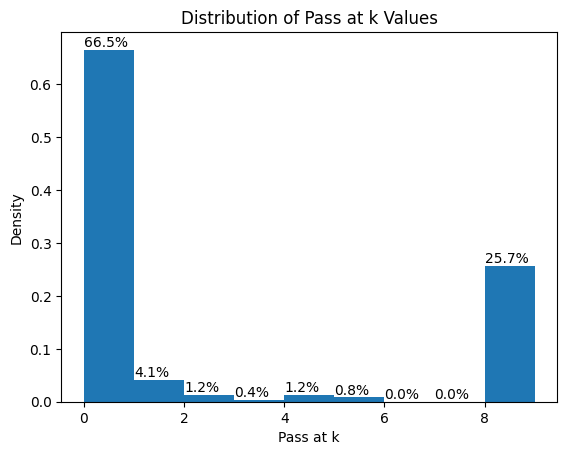

In [73]:
# pass_at_k_mapping
# plot the distribution of pass at k
import matplotlib.pyplot as plt
import numpy as np

pass_at_k_mapping_ = pass_at_k_mapping.copy()
# change all inf to (n_steps + 1)
pass_at_k_mapping_ = {
    k: v if v < 100 else step_size + 1
    for k, v in pass_at_k_mapping_.items()
}
# Create histogram and get the values
counts, bins, patches = plt.hist(
    list(pass_at_k_mapping_.values()), 
    bins=range(step_size + 2), 
    density=True,
)

# Add value labels on top of each bar
for i in range(len(counts)):
    plt.text(bins[i], counts[i], f'{(counts[i] * 100):.1f}%', ha='left', va='bottom')

plt.xlabel('Pass at k')
plt.ylabel('Density') 
plt.title('Distribution of Pass at k Values')
plt.show()

In [88]:

correct_set = set()
wrong_set = set()
ran_rounds = {}
completed_set = set()
entropy_threshold = 0.003
N = original_df['ground_truth'].nunique()
p = 0.5

max_num_iters = step_size - 1
for iter in range(max_num_iters):
    entropy_this_iter = {}
    correct_this_iter = {}
    df = original_df[original_df['n_attempts'] == iter]
    for i, item in df.iterrows():
        entropy = item['before_feedback_entropy']
        ground_truth = item['ground_truth']
        is_correct = item['pass_at_k'] <= iter
        if ground_truth in completed_set:
            continue
        entropy_this_iter[ground_truth] = entropy
        correct_this_iter[ground_truth] = is_correct
    
    if not entropy_this_iter:
        break
    
    entropy_this_iter = sorted(
        entropy_this_iter.items(),
        key=lambda x: x[1], 
        reverse=False
    )
    # Select the top p percentile to terminate, and further select the 
    upper_bound = int(p * len(entropy_this_iter))
    if iter == step_size - 1:
        upper_bound = len(entropy_this_iter)

    for i, (ground_truth, entropy) in enumerate(entropy_this_iter):
        if i <= upper_bound or entropy < entropy_threshold:
            is_correct = correct_this_iter[ground_truth]
            # print(ground_truth, is_correct)
            if is_correct:
                correct_set.add(ground_truth)
            else:
                wrong_set.add(ground_truth)
            completed_set.add(ground_truth)
            ran_rounds[ground_truth] = iter + 1
    
    print(
        iter, 
        f"{(100 * len(correct_set) / N):.2f}%, ",
        f"{len(correct_set) = }, ",
        f"{len(wrong_set) = }, ",
        f"{len(completed_set) = }, ",
        f"{N = }", 
    )



0 47.56% len(correct_set) = 117 len(wrong_set) = 7 len(completed_set) = 124 N = 246
1 61.38% len(correct_set) = 151 len(wrong_set) = 35 len(completed_set) = 186 N = 246
2 65.45% len(correct_set) = 161 len(wrong_set) = 56 len(completed_set) = 217 N = 246
3 68.29% len(correct_set) = 168 len(wrong_set) = 64 len(completed_set) = 232 N = 246
4 69.51% len(correct_set) = 171 len(wrong_set) = 69 len(completed_set) = 240 N = 246
5 69.92% len(correct_set) = 172 len(wrong_set) = 72 len(completed_set) = 244 N = 246
6 70.33% len(correct_set) = 173 len(wrong_set) = 73 len(completed_set) = 246 N = 246
